# Model interpretability

## Pair representation

In [25]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.stats import pearsonr

In [26]:
results_w_outputs = torch.load('predictions_w_outputs.pt')

In [27]:
# To generate predictions, we recentred the complex, so we need to add the centre of mass of the protein to the predicted coordinates
test_complexes = torch.load('data/processed/timesplit_test/rec_input_chain_ids.pt')
coms = []
for rec in test_complexes:
    c = torch.mean(rec['c_alpha_coords'], dim=0)
    coms.append(c)

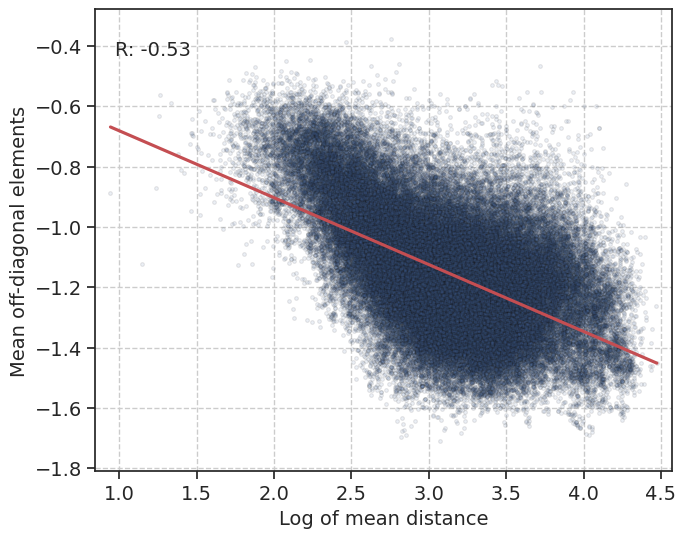

In [28]:
cleaned_pair_reps = []
for pred, pair_rep in zip(results_w_outputs['predictions'], results_w_outputs['z_pre_struct']):
    n_lig_atoms = pred.shape[1]
    pair_rep = pair_rep.squeeze()
    pair_rep_lower = torch.transpose(pair_rep[-n_lig_atoms:,:-n_lig_atoms], 0, 1)
    pair_rep_upper = pair_rep[:-n_lig_atoms,-n_lig_atoms:]
    symm_pair_rep = (pair_rep_lower + pair_rep_upper)/2
    symm_pair_rep = torch.mean(symm_pair_rep, dim=-1)
    symm_pair_rep = torch.mean(symm_pair_rep, dim=-1)
    cleaned_pair_reps.append(symm_pair_rep)

corr_coords = []
for prediction, com in zip(results_w_outputs['predictions'], coms):
    corr_c = prediction + com
    corr_coords.append(corr_c)

dists, pair_reps_to_arr = [], []
for rec, pred_coords, pair_rep in zip(test_complexes, corr_coords, cleaned_pair_reps):
    c_alpha = rec['c_alpha_coords']
    pairwise_dist = torch.mean(torch.cdist(c_alpha, pred_coords.to(dtype=float)).squeeze(), dim=-1)
    dists.append(pairwise_dist.numpy())
    pair_reps_to_arr.append(pair_rep.numpy())

pair_reps_arr = np.hstack(pair_reps_to_arr)
dists_arr = np.hstack(dists)
X = np.log(dists_arr)
Y = pair_reps_arr
sb.set(style="ticks")
_, ax = plt.subplots(figsize=(7.45,6))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Mean off-diagonal elements', fontsize=14)
plt.xlabel('Log of mean distance', fontsize=14)
ax.scatter(X, Y, s = 7, edgecolor = 'k', linewidths = 0.8, alpha = 0.1, zorder=2)
sb.regplot(x=X, y=Y, scatter=False, color="r", truncate = True, ax=ax)
ax.grid(linestyle='--', linewidth=1)
plt.xlim(min(X)-0.1, max(X)+0.1)
plt.ylim(min(Y)-0.1, max(Y)+0.1)
plt.text(0.1, 0.9, f'R: {np.round(pearsonr(X,Y).statistic, 2)}', horizontalalignment='center',
         fontsize=14, transform = ax.transAxes)
plt.show()

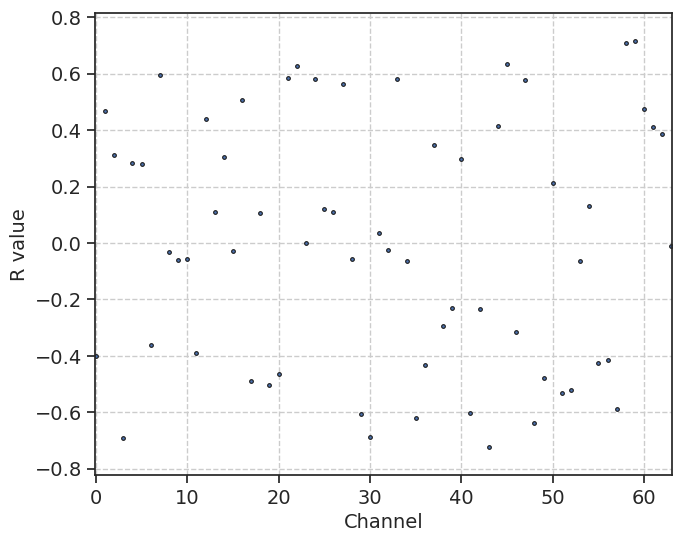

-0.7229982714213563 0.7144114503723434


In [29]:
corr_coords = []
for prediction, com in zip(results_w_outputs['predictions'], coms):
    corr_c = prediction + com
    corr_coords.append(corr_c)

dists = []
for rec, pred_coords in zip(test_complexes, corr_coords):
    c_alpha = rec['c_alpha_coords']
    pairwise_dist = torch.mean(torch.cdist(c_alpha, pred_coords.to(dtype=float)).squeeze(), dim=-1)
    dists.append(pairwise_dist.numpy())

r_values_channel = []
for channel in range(0, 64,1):
    cleaned_pair_reps_bsc = []
    for pred, pair_rep in zip(results_w_outputs['predictions'], results_w_outputs['z_pre_struct']):
        n_lig_atoms = pred.shape[1]
        pair_rep = pair_rep.squeeze()
        pair_rep_lower = torch.transpose(pair_rep[-n_lig_atoms:,:-n_lig_atoms], 0, 1)
        pair_rep_upper = pair_rep[:-n_lig_atoms,-n_lig_atoms:]
        symm_pair_rep = (pair_rep_lower + pair_rep_upper)/2
        symm_pair_rep = symm_pair_rep[:,:,channel]
        symm_pair_rep = torch.mean(symm_pair_rep, dim=-1)
        cleaned_pair_reps_bsc.append(np.array(symm_pair_rep))
    dist_bsc_arr = np.hstack(dists)
    pair_rep_bsc_arr = np.hstack(cleaned_pair_reps_bsc)
    X = np.log(dist_bsc_arr)
    Y = pair_rep_bsc_arr
    r_values_channel.append(pearsonr(X,Y).statistic)

X = [i for i in range(0,64,1)]
Y = r_values_channel
sb.set(style="ticks")
_, ax = plt.subplots(figsize=(7.45,6))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('R value', fontsize=14)
plt.xlabel('Channel', fontsize=14)
ax.scatter(X, Y, s = 7, edgecolor = 'k', linewidths = 0.8, alpha = 1, zorder=2)
ax.grid(linestyle='--', linewidth=1)
plt.xlim(min(X)-0.1, max(X)+0.1)
plt.ylim(min(Y)-0.1, max(Y)+0.1)
plt.show()
print(min(r_values_channel), max(r_values_channel))

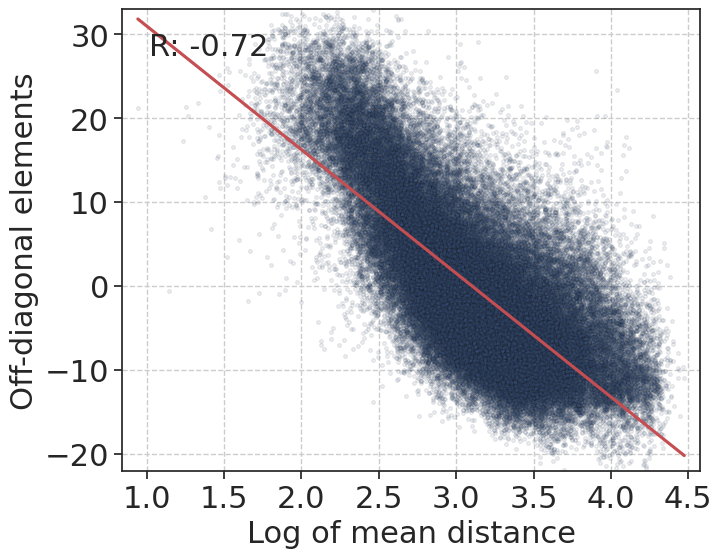

In [31]:
cleaned_pair_reps_bsc = []
best_channel = np.argmin(r_values_channel)
for pred, pair_rep in zip(results_w_outputs['predictions'], results_w_outputs['z_pre_struct']):
    n_lig_atoms = pred.shape[1]
    pair_rep = pair_rep.squeeze()
    pair_rep_lower = torch.transpose(pair_rep[-n_lig_atoms:,:-n_lig_atoms], 0, 1)
    pair_rep_upper = pair_rep[:-n_lig_atoms:,-n_lig_atoms:]
    symm_pair_rep = (pair_rep_lower + pair_rep_upper)/2
    symm_pair_rep = symm_pair_rep[:,:,best_channel]
    symm_pair_rep = torch.mean(symm_pair_rep, dim=-1)
    cleaned_pair_reps_bsc.append(np.array(symm_pair_rep))

dist_bsc_arr = np.hstack(dists)
pair_rep_bsc_arr = np.hstack(cleaned_pair_reps_bsc)
X = np.log(dist_bsc_arr)
Y = pair_rep_bsc_arr
sb.set(style="ticks")
_, ax = plt.subplots(figsize=(7.45,6))
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.ylabel('Off-diagonal elements', fontsize=22)
plt.xlabel('Log of mean distance', fontsize=22)
ax.scatter(X, Y, s = 7, edgecolor = 'k', linewidths = 0.8, alpha = 0.1, zorder=2)
sb.regplot(x=X, y=Y, scatter=False, color="r", truncate = True, ax=ax)
ax.grid(linestyle='--', linewidth=1)
plt.xlim(min(X)-0.1, max(X)+0.1)
plt.ylim(min(Y)-0.1, max(Y)+0.1)
plt.text(0.15, 0.9, f'R: {np.round(pearsonr(X,Y).statistic, 2)}', horizontalalignment='center',
         fontsize=22, transform = ax.transAxes)
plt.savefig('pair_rep_interpret.jpg', bbox_inches='tight', format='jpg')
plt.show()

In [32]:
pearsonr(X,Y)

PearsonRResult(statistic=-0.7229982714213563, pvalue=0.0)

## Single representation

In [33]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.stats import pearsonr
from dataset.process_mols import read_molecule
from mordred import Calculator, descriptors
import os
from rdkit import Chem

results_w_single_rep = torch.load('predictions-w-lig-s.pt')
results_w_single_rep.keys()

dict_keys(['predictions', 'targets', 'masks', 'names', 's_pre_struct'])

In [34]:
lig_single_reps = [s[:, -m.shape[1]:].squeeze() for s, m in zip(results_w_single_rep['s_pre_struct'], results_w_single_rep['masks'])]

In [35]:
pred_ligs = [
    read_molecule(f"checkpoints/quickbind_default/sdffiles/{name}_pred.sdf", remove_hs=True)
    for name in results_w_single_rep['names']
]
true_ligs = []
for name in results_w_single_rep['names']:
    true_lig = read_molecule(os.path.join('data/PDBBind/', name, f'{name}_ligand.mol2'), remove_hs=False)
    if true_lig is None:
        true_lig = read_molecule(os.path.join('data/PDBBind/', name, f'{name}_ligand.sdf'), remove_hs=False)
    true_ligs.append(true_lig)

In [36]:
calc = Calculator(descriptors, ignore_3D=False)

In [ ]:
df = calc.pandas(true_ligs)

In [38]:
desc_of_interest = [
    'PNSA5', 'PPSA5', 'DPSA5', 'FNSA5', 'FPSA5', 'WNSA5', 'WPSA5',
    'RNCG', 'RPCG', 'RNCS', 'RPCS', 'TASA', 'TPSA', 'RASA', 'RPSA', 'Lipinski', 'apol', 'bpol', 'SLogP', 'TopoPSA'
]

In [39]:
pooled_single_reps = np.array([torch.mean(s, dim=0).numpy() for s in lig_single_reps])

In [40]:
best_r_value = {}
for desc in df:
    if desc not in desc_of_interest:
        continue

    desc_array = df[desc].to_numpy()
    r_values_channel = []
    for c in range(0, 64,1):
        channel = pooled_single_reps[:, c]
        clean_X, clean_Y = [], []
        for s, f in zip(channel, desc_array):
            if isinstance(f, float):
                clean_X.append(s)
                clean_Y.append(f)
        if len(clean_Y) < 100:
            r_values_channel.append(np.nan)
        else:
            r_values_channel.append(pearsonr(clean_X,clean_Y).statistic)

    if abs(max(r_values_channel, key=abs)) > 0.6:
        print(f'{desc}: Best correlation: {max(r_values_channel, key=abs)} in channel {np.argmax(r_values_channel) if max(r_values_channel, key=abs) > 0.7 else np.argmin(r_values_channel)}')

PPSA5: Best correlation: 0.7147867402986187 in channel 27
DPSA5: Best correlation: 0.6859722364164571 in channel 31
WNSA5: Best correlation: -0.6966497116315399 in channel 27
WPSA5: Best correlation: 0.7508016745328572 in channel 27
TASA: Best correlation: -0.7244127529445541 in channel 57
TPSA: Best correlation: 0.6505839657075342 in channel 31
apol: Best correlation: 0.7380778753606145 in channel 27
bpol: Best correlation: 0.7646820668806744 in channel 54
TopoPSA: Best correlation: 0.7067700000529543 in channel 27


- PPSA5: partial positive surface area.
- DPSA5: difference in charged partial surface area.
- WNSA5: surface weighted charged partial negative surface area.
- WPSA5: surface weighted charged partialpositive surface area.
- TASA: total hydrophobic surfac area.
- TPSA: total polar surface area.
- apol: atomic polarisability
- bpol: bond polarisability.
- TopoPSA: topological polar surface area.

In [41]:
MW, ALOGP, HBA, HBD, PSA, ROTB, AROM = [], [], [], [], [], [], []
for mol in pred_ligs:
    qed_props = Chem.QED.properties(mol)
    MW.append(qed_props.MW)
    ALOGP.append(qed_props.ALOGP)
    HBA.append(qed_props.HBA)
    HBD.append(qed_props.HBD)
    PSA.append(qed_props.PSA)
    ROTB.append(qed_props.ROTB)
    AROM.append(qed_props.AROM)

In [42]:
rdkit_descs = [MW, ALOGP, HBA, HBD, PSA, ROTB, AROM]
rdkit_descs_names = ["MW", "ALOGP", "HBA", "HBD", "PSA", "ROTB", "AROM"]

for desc, name in zip(rdkit_descs, rdkit_descs_names):
    r_values_channel = []
    for c in range(0, 64,1):
        channel = pooled_single_reps[:, c]
        r_values_channel.append(pearsonr(channel,desc).statistic)
    if abs(max(r_values_channel, key=abs)) > 0.6:
        print(f'{name}: Best correlation: {max(r_values_channel, key=abs)} in channel {np.argmax(r_values_channel) if max(r_values_channel, key=abs) > 0.7 else np.argmin(r_values_channel)}')

MW: Best correlation: 0.7329043203860675 in channel 27
HBA: Best correlation: 0.6348310406703428 in channel 11
HBD: Best correlation: 0.6984956160938895 in channel 31
PSA: Best correlation: 0.7050522030330199 in channel 27
ROTB: Best correlation: 0.7623985912755423 in channel 27


- MW: molecular weight.
- HBA: number of hydrogen bond acceptors.
- HBD: number of hydrogen bond donor.
- PSA: polar surface area.
- ROTB: number of rotatable bonds.

In [43]:
desc = MW
r_values_channel = []
for c in range(0, 64,1):
    channel = pooled_single_reps[:, c]
    r_values_channel.append(pearsonr(channel,desc).statistic)
best_channel = np.argmax(r_values_channel) if max(r_values_channel, key=abs) > 0.6 else np.argmin(r_values_channel)
X = pooled_single_reps[:, best_channel]
Y = desc
print('p-value:',  pearsonr(X,Y).pvalue)

p-value: 2.338809308916659e-62


p-value: 2.401416417995437e-42


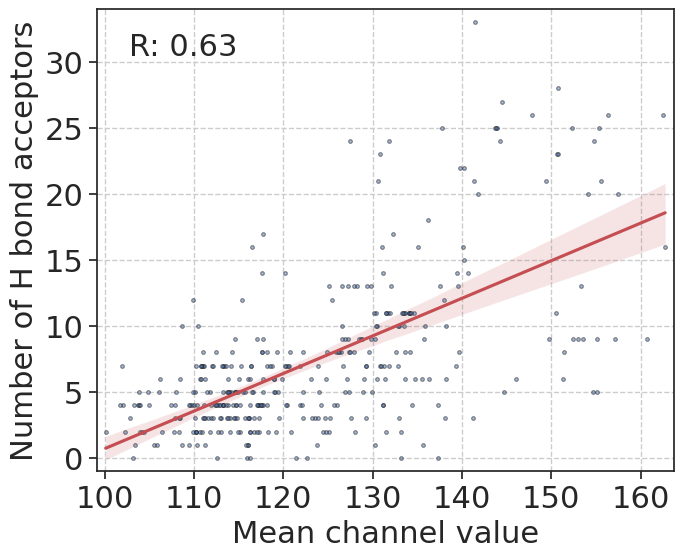

In [44]:
desc = HBA
r_values_channel = []
for c in range(0, 64,1):
    channel = pooled_single_reps[:, c]
    r_values_channel.append(pearsonr(channel,desc).statistic)
best_channel = np.argmax(r_values_channel) if max(r_values_channel, key=abs) > 0.6 else np.argmin(r_values_channel)

X = pooled_single_reps[:, best_channel]
Y = desc
sb.set(style="ticks")
_, ax = plt.subplots(figsize=(7.45,6))
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.ylabel('Number of H bond acceptors', fontsize=22)
plt.xlabel('Mean channel value', fontsize=22)
ax.scatter(X, Y, s = 7, edgecolor = 'k', linewidths = 0.8, alpha = 0.5, zorder=2)
sb.regplot(x=X, y=Y, scatter=False, color="r", truncate = True, ax=ax)
ax.grid(linestyle='--', linewidth=1)
plt.xlim(min(X)-1, max(X)+1)
plt.ylim(min(Y)-1, max(Y)+1)
plt.text(0.15, 0.9, f'R: {np.round(pearsonr(X,Y).statistic, 2)}', horizontalalignment='center',
         fontsize=22, transform = ax.transAxes)
print('p-value:',  pearsonr(X,Y).pvalue)
plt.savefig('single_rep_HBA.jpg', bbox_inches='tight', format='jpg')
plt.show()

p-value: 2.0730283621521168e-54


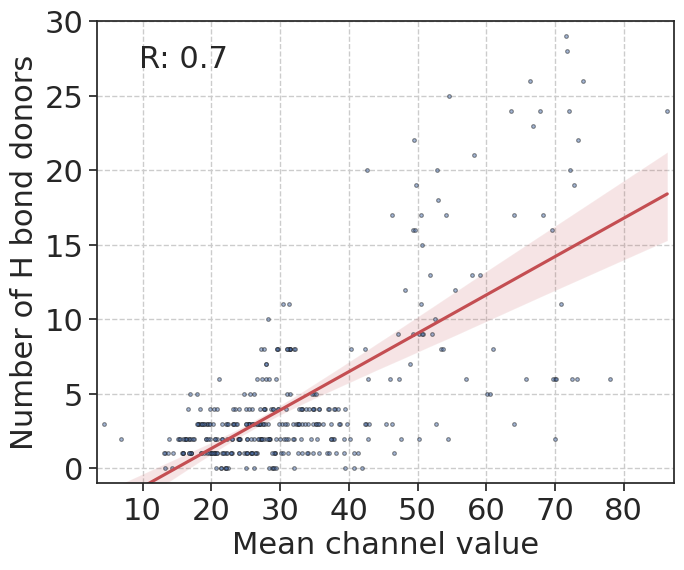

In [45]:
desc = HBD
r_values_channel = []
for c in range(0, 64,1):
    channel = pooled_single_reps[:, c]
    r_values_channel.append(pearsonr(channel,desc).statistic)
best_channel = np.argmax(r_values_channel) if max(r_values_channel, key=abs) > 0.6 else np.argmin(r_values_channel)

X = pooled_single_reps[:, best_channel]
Y = desc
sb.set(style="ticks")
_, ax = plt.subplots(figsize=(7.45,6))
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.ylabel('Number of H bond donors', fontsize=22)
plt.xlabel('Mean channel value', fontsize=22)
ax.scatter(X, Y, s = 7, edgecolor = 'k', linewidths = 0.8, alpha = 0.5, zorder=2)
sb.regplot(x=X, y=Y, scatter=False, color="r", truncate = True, ax=ax)
ax.grid(linestyle='--', linewidth=1)
plt.xlim(min(X)-1, max(X)+1)
plt.ylim(min(Y)-1, max(Y)+1)
plt.text(0.15, 0.9, f'R: {np.round(pearsonr(X,Y).statistic, 2)}', horizontalalignment='center',
         fontsize=22, transform = ax.transAxes)
print('p-value:',  pearsonr(X,Y).pvalue)
plt.savefig('single_rep_HBD.jpg', bbox_inches='tight', format='jpg')
plt.show()

In [46]:
desc = PSA
r_values_channel = []
for c in range(0, 64,1):
    channel = pooled_single_reps[:, c]
    r_values_channel.append(pearsonr(channel,desc).statistic)
best_channel = np.argmax(r_values_channel) if max(r_values_channel, key=abs) > 0.6 else np.argmin(r_values_channel)
X = pooled_single_reps[:, best_channel]
Y = desc
print('p-value:',  pearsonr(X,Y).pvalue)

p-value: 7.782414865092585e-56


p-value: 3.179722066008195e-70


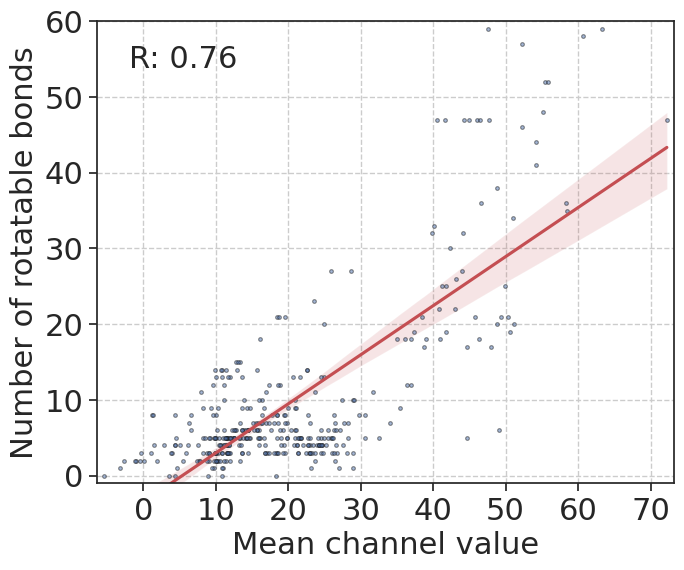

In [47]:
desc = ROTB
r_values_channel = []
for c in range(0, 64,1):
    channel = pooled_single_reps[:, c]
    r_values_channel.append(pearsonr(channel,desc).statistic)
best_channel = np.argmax(r_values_channel) if max(r_values_channel, key=abs) > 0.6 else np.argmin(r_values_channel)

X = pooled_single_reps[:, best_channel]
Y = desc
sb.set(style="ticks")
_, ax = plt.subplots(figsize=(7.45,6))
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.ylabel('Number of rotatable bonds', fontsize=22)
plt.xlabel('Mean channel value', fontsize=22)
ax.scatter(X, Y, s = 7, edgecolor = 'k', linewidths = 0.8, alpha = 0.5, zorder=2)
sb.regplot(x=X, y=Y, scatter=False, color="r", truncate = True, ax=ax)
ax.grid(linestyle='--', linewidth=1)
plt.xlim(min(X)-1, max(X)+1)
plt.ylim(min(Y)-1, max(Y)+1)
plt.text(0.15, 0.9, f'R: {np.round(pearsonr(X,Y).statistic, 2)}', horizontalalignment='center',
         fontsize=22, transform = ax.transAxes)
print('p-value:',  pearsonr(X,Y).pvalue)
plt.savefig('single_rep_ROTB.jpg', bbox_inches='tight', format='jpg')
plt.show()

p-value: 1.2329292199590152e-59


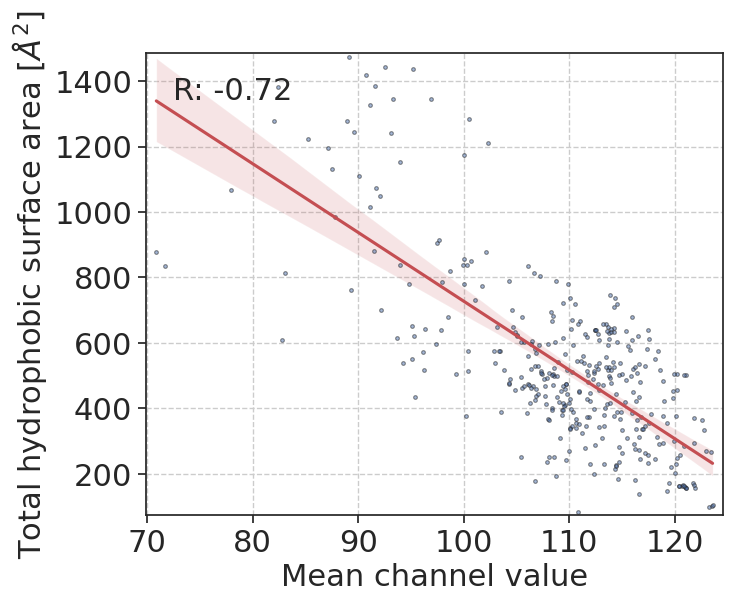

In [48]:
desc_array = df['TASA'].to_numpy()
channel = pooled_single_reps[:, 57]
clean_X, clean_Y = [], []
for s, f in zip(channel, desc_array):
    if isinstance(f, float):
        clean_X.append(s)
        clean_Y.append(f)

X = clean_X
Y = clean_Y
sb.set(style="ticks")
_, ax = plt.subplots(figsize=(7.45,6))
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.ylabel('Total hydrophobic surface area [$\AA^2$]', fontsize=22)
plt.xlabel('Mean channel value', fontsize=22)
ax.scatter(X, Y, s = 7, edgecolor = 'k', linewidths = 0.8, alpha = 0.5, zorder=2)
sb.regplot(x=X, y=Y, scatter=False, color="r", truncate = True, ax=ax)
ax.grid(linestyle='--', linewidth=1)
plt.xlim(min(X)-1, max(X)+1)
plt.ylim(min(Y)-10, max(Y)+10)
plt.text(0.15, 0.9, f'R: {np.round(pearsonr(X,Y).statistic, 2)}', horizontalalignment='center',
         fontsize=22, transform = ax.transAxes)
print('p-value:',  pearsonr(X,Y).pvalue)
plt.savefig('single_rep_THSA.jpg', bbox_inches='tight', format='jpg')
plt.show()